In [1]:
!pip install numpyro;

## GP for binary classification (in Numpyro)

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &=& \mathbf{L} \cdot \boldsymbol{\eta} + \beta, \text{ where }
\mathbf{L} = \text{cholesky}(\mathbf{K}) \\
\eta_n &\sim& \text{Normal(0, 1)}, \text{ for } n=1,\dots,N \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
$$

Note: 
- $\mathbf{K}$ is an $N\times N$ covariance matrix where
  $K_{n,m} = \alpha^2\exp\left(-{\left\lVert\mathbf{x}_n - \mathbf{x}_m\right\rVert}^2_2\big/\rho^{2}\right)$.
- Each $\mathbf{x}_n$ is an observed 2-dimensional locations, for $n=1,\dots,N$.
- The model above is the same as the more explicit model below. But the model above mixes slowly with ADVI, HMC, and NUTS; while the model above mixes much more quickly.

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &\sim& \text{MvNormal}(\beta \cdot \mathbf{1}_N, K) \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(1, 1) \\
\end{eqnarray}
$$

In [1]:
!echo "Last updated: `date`"

Last updated: Fri 21 Aug 2020 02:46:22 PM PDT


In [3]:
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
from jax import random, lax
import jax.numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, ELBO
from numpyro.infer import MCMC, NUTS, HMC
import numpy as onp
from sklearn.datasets import make_moons
from tqdm import trange

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

numpyro.enable_x64()

In [4]:
def plot_data(X, y, **kwargs):
    colors = onp.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], **kwargs)


def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

In [5]:
def sample_posterior(guide, params, nsamples, seed=1):
    samples = guide.get_posterior(params).sample(random.PRNGKey(seed), (nsamples, ))
    # NOTE: Samples are arranged in alphabetical order.
    #       Not in the order in which they appear in the
    #       model. This is different from pyro.
    return dict(alpha=onp.exp(samples[:, 0]),
                beta=samples[:, 1],
                eta=samples[:, 2:52],
                rho=onp.exp(samples[:, -1]))

sigmoid = lambda x: 1 / (1 + np.exp(-x))

def gp_predict(X, Xnew, samples, i, eps=1e-6):
    kernel = samples['alpha'][i]**2 * RBF(samples['rho'][i]) 
    kernel += eps * WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=0)
    f = compute_f(samples['alpha'][i],
                  samples['rho'][i],
                  samples['beta'][i],
                  samples['eta'][i], X)
    gpr.fit(X, f)
    return sigmoid(gpr.predict(Xnew))

def plot_kernel_params(samples, algo, kernel_params=['alpha', 'rho', 'beta'],
                       figsize=np.array([8, 3])):
    plt.figure(figsize=figsize)
    for i in range(len(kernel_params)):
        plt.subplot(1, len(kernel_params), i + 1)
        param = kernel_params[i]
        plt.hist(samples[param], bins=30, density=True)
        plt.xlabel(param)
        plt.ylabel('density')
        plt.title(f"Histograhm of {param} ({algo})")
    plt.tight_layout()   

def plot_uq(samples, X, nnew, algo, figsize=np.array([8, 3]), grid_eps=0.5):
    Xnew, x0, x1 = gen_grid(X, nnew, return_each=True, eps=grid_eps)
    preds = np.stack([gp_predict(X, Xnew, samples, i)
                      for i in trange(samples['rho'].shape[0])])
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(X, y, edgecolor="orange")

    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, preds.std(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('Oranges'), vmin=0)
    plt.title(f'Posterior SD function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(X, y, edgecolor="black")
    plt.tight_layout()

    # Plot kernel parameters
    plot_kernel_params(samples, algo, figsize=figsize)

## Data

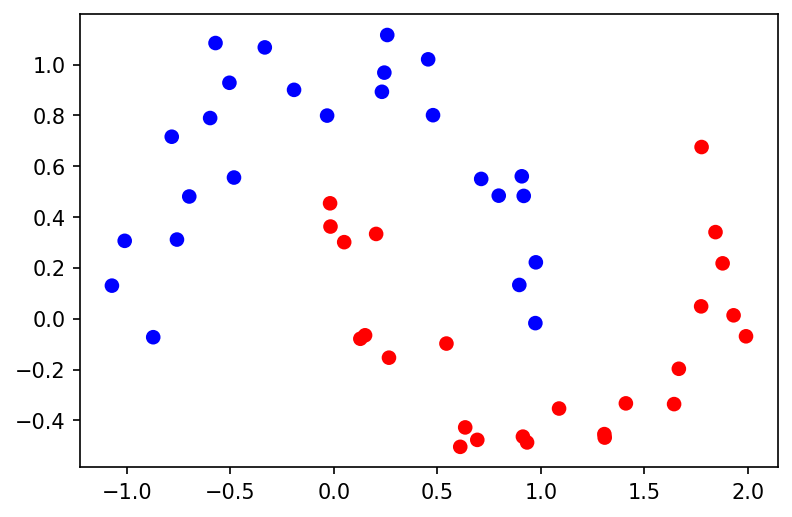

In [6]:
# Make data
X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
plot_data(X, y)

## Model

In [7]:
# TODO: This is not efficient.
def sq_exp_cov(X, alpha, rho):
    D = np.linalg.norm(X[:, None] - X, ord=2, axis=-1)
    return alpha * alpha * np.exp(-0.5 * np.power(D / rho, 2))

def compute_f(alpha, rho, beta, eta, X, jitter=1e-6):
    N = X.shape[0]
    K = sq_exp_cov(X, alpha, rho) + np.eye(N) * jitter
    L = np.linalg.cholesky(K)
    return np.matmul(L, eta) + beta

# GP Binary Classifier.
def GPC(X, y):
    N = y.shape[0]
    
    # Priors.
    alpha = numpyro.sample('alpha', dist.LogNormal(0, 1))
    rho = numpyro.sample('rho', dist.LogNormal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(0, 1))
    eta = numpyro.sample('eta', dist.Normal(np.zeros(N), 1))

    # Latent function.
    f = compute_f(alpha, rho, beta, eta, X, 1e-3)
   
    # Likelihood.
    numpyro.sample('obs', dist.Bernoulli(logits=f), obs=y)

## HMC

In [8]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size
hmc = MCMC(HMC(GPC, step_size=.05, trajectory_length=1,
               adapt_step_size=False, adapt_mass_matrix=False),
           num_samples=500, num_warmup=500)
hmc.run(rng_key, X, y)

hmc_samples = hmc.get_samples()

sample: 100%|██████████| 1000/1000 [00:10<00:00, 97.31it/s, 20 steps of size 5.00e-02. acc. prob=0.92]


CPU times: user 16.3 s, sys: 6.17 s, total: 22.5 s
Wall time: 15.2 s


100%|██████████| 500/500 [00:14<00:00, 34.09it/s]


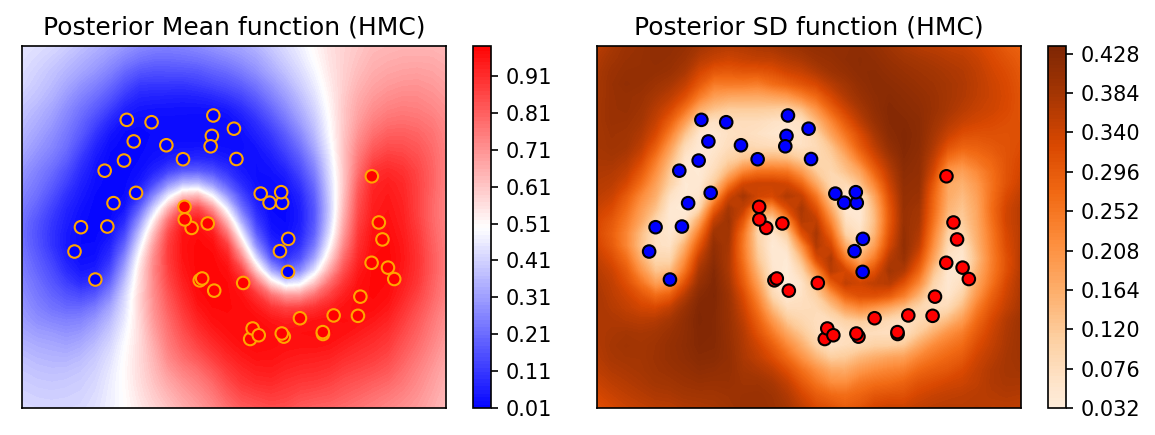

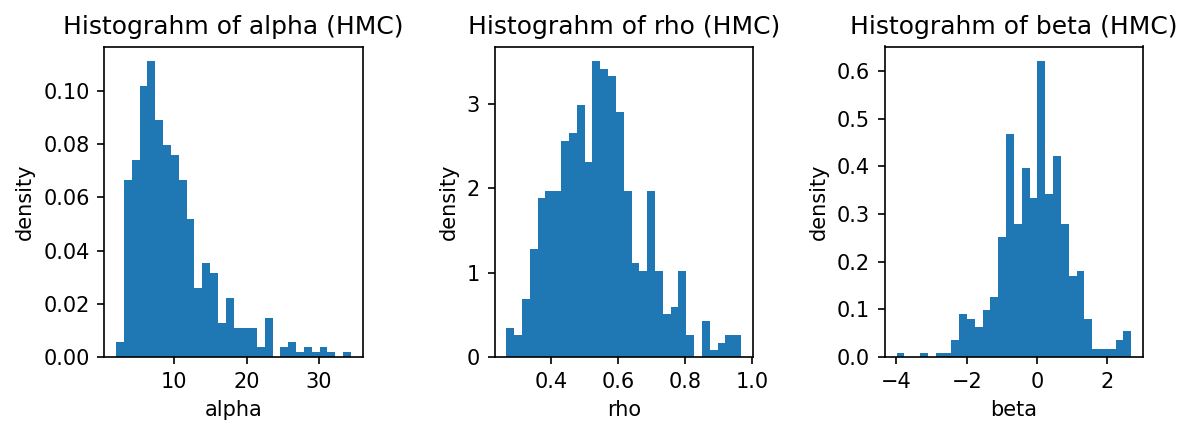

In [9]:
plot_uq(hmc_samples, X, 30, "HMC")

## NUTS

In [10]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size

nuts = MCMC(NUTS(GPC, target_accept_prob=0.8, max_tree_depth=10),
            num_samples=500, num_warmup=500)
nuts.run(rng_key, X, y)

nuts_samples = nuts.get_samples()

sample: 100%|██████████| 1000/1000 [00:18<00:00, 54.46it/s, 31 steps of size 1.37e-01. acc. prob=0.92]


CPU times: user 20.6 s, sys: 9.94 s, total: 30.6 s
Wall time: 18.6 s


100%|██████████| 500/500 [00:14<00:00, 33.99it/s]


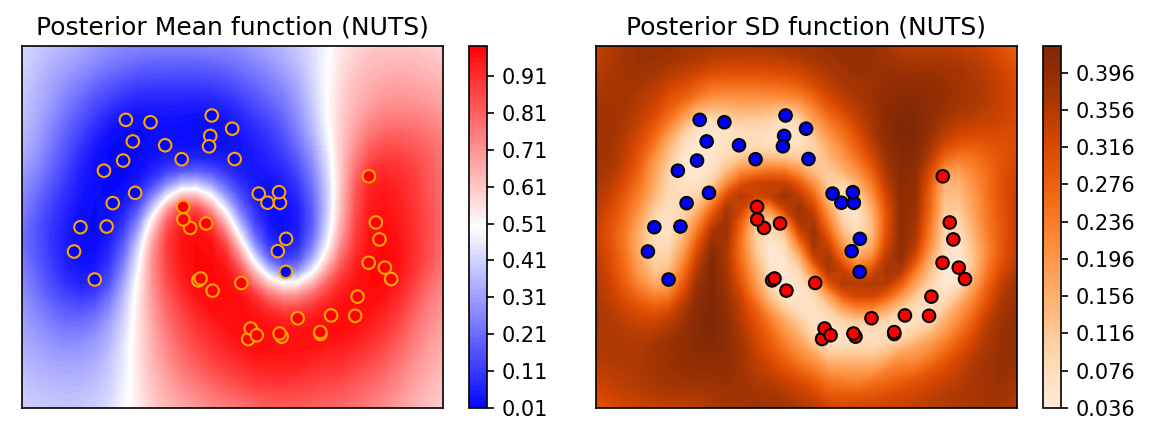

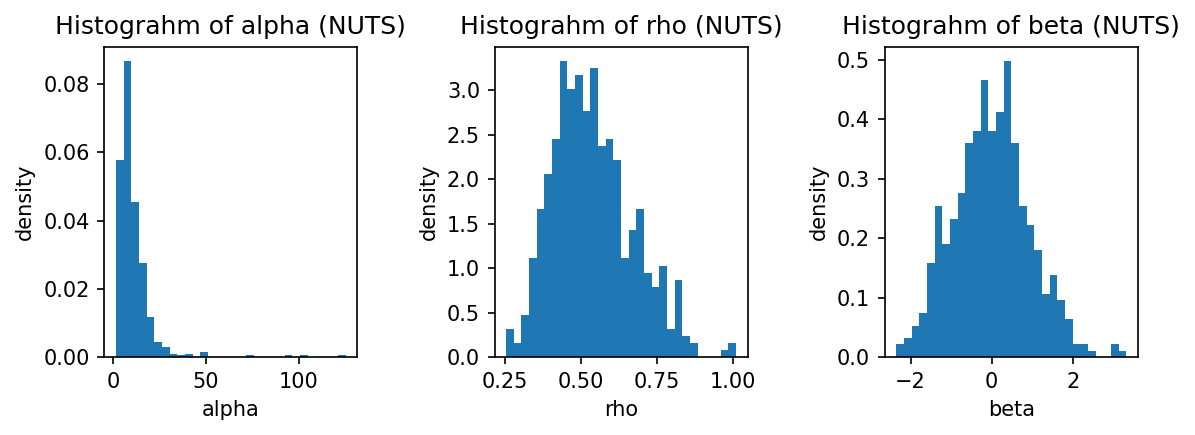

In [11]:
plot_uq(nuts_samples, X, 30, "NUTS")

## ADVI

- Learn more about [ADVI in Numpyro][1]

[1]: http://num.pyro.ai/en/stable/svi.html



In [12]:
%%time

# Compile
guide = AutoDiagonalNormal(GPC)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(GPC, guide, optimizer, loss=ELBO())
init_state = svi.init(random.PRNGKey(1), X, y)

CPU times: user 353 ms, sys: 197 ms, total: 550 ms
Wall time: 338 ms


CPU times: user 4.68 s, sys: 428 ms, total: 5.11 s
Wall time: 4.59 s


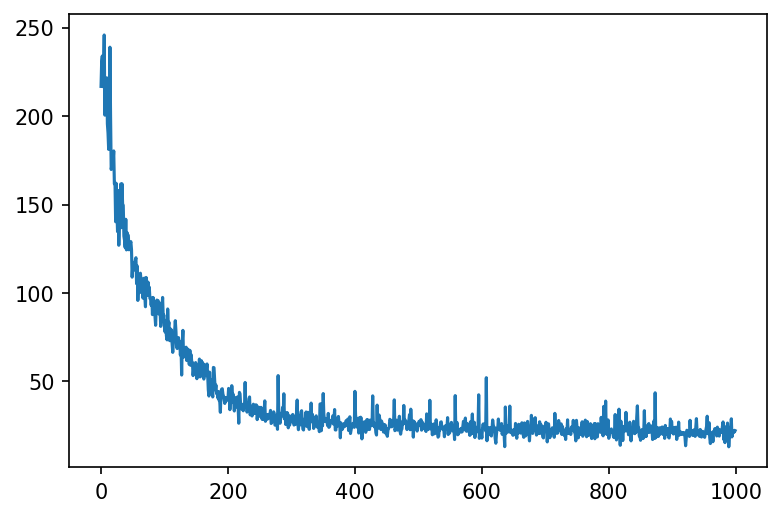

In [13]:
%%time

# Run optimizer
state, losses = lax.scan(lambda state, i: 
                         svi.update(state, X, y), init_state, np.arange(1000))

# Extract surrogate posterior.
params = svi.get_params(state)
plt.plot(losses);
advi_samples = sample_posterior(guide, params, nsamples=500, seed=1)

100%|██████████| 500/500 [00:10<00:00, 47.41it/s]


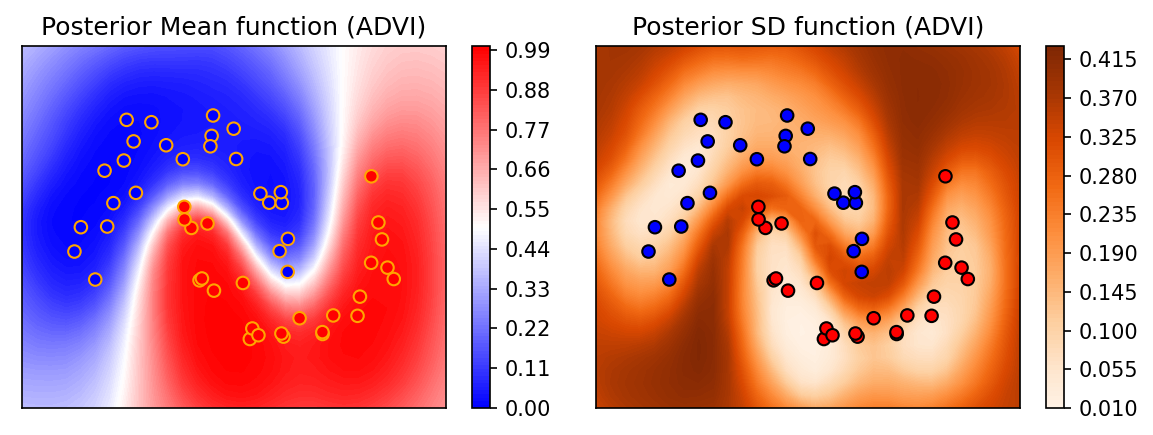

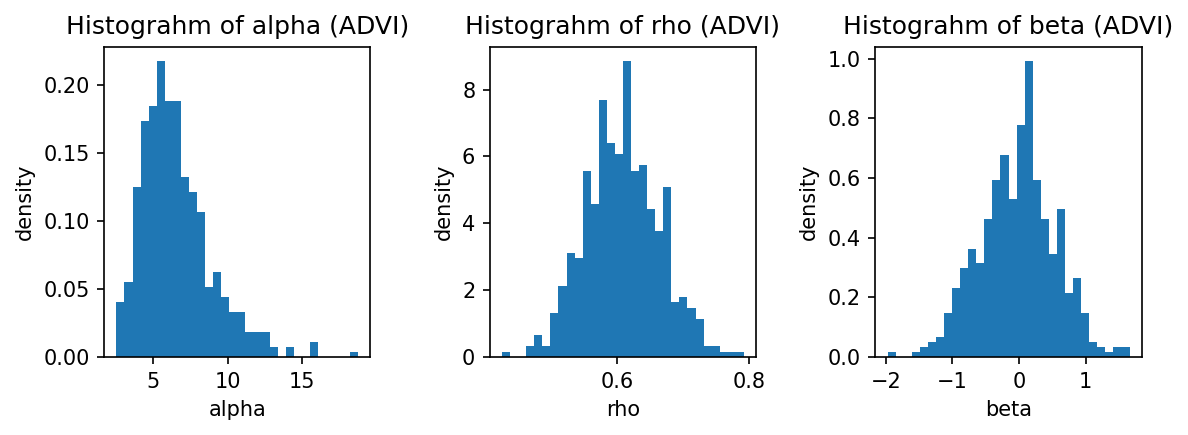

In [14]:
plot_uq(advi_samples, X, 30, "ADVI")